In [199]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from numpy.random import multivariate_normal
from sklearn.mixture import GaussianMixture

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation

# Task 1

In [84]:
df = pd.read_csv('../googleplaystore.csv')
row_10472 = df.loc[10472,:]
df.loc[10472,:] = [row_10472['App'], row_10472['Content Rating'], row_10472['Category'], row_10472['Rating'], row_10472['Reviews'],
                   row_10472['Size'], row_10472['Installs'], row_10472['Type'], row_10472['Price'], row_10472['Android Ver'], 
                   row_10472['Genres'], row_10472['Last Updated'], row_10472['Current Ver']]

df.drop(['Type','Category','Current Ver','Android Ver'],axis=1, inplace=True)

lastUpdated = pd.to_datetime(df['Last Updated'])
df.loc[:,'Last Updated'] = pd.to_datetime(df.loc[:,'Last Updated'])
df.loc[:,'Last Updated'] = df.loc[:,'Last Updated'].map(lambda x: (datetime.today()-x).days)

df.loc[:,'Size'] = df.loc[:,'Size'].map(lambda x: float(x[:-1])*1000000 if x[-1] == 'M' else float(x[:-1])*1000 if x[-1] == 'k' else x)

#replacing $ in price
df['Price'].replace(
    {r'\$([0-9]*\.*[0-9]*)': r'\1'},
    inplace = True,
    regex = True)

#replacing , in installs
df['Installs'].replace(
    {r'([0-9]*)\,*([0-9]*)\,*([0-9]*)\,*([0-9]*)\+': r'\1\2\3\4'},
    inplace = True,
    regex = True)

#where varies with device 
df['Size'].replace("Varies with device", float("NaN"), inplace=True)
df.drop(df[pd.to_numeric(df.Size, errors = 'coerce').isnull()].index,
                  axis = 0,
                  inplace = True)
df.dropna(inplace=True)

#categorical values encoding (using label encoding https://pbpython.com/categorical-encoding.html#approach-2-label-encoding)
#print(df['Genres'].unique())
df = df.astype({
    'Genres':             'category',
    'Content Rating':     'category'
})

df['Genres Category'] = df['Genres'].cat.codes
df['Content Rating Category'] = df['Content Rating'].cat.codes

feature_columns = ['Reviews', 'Size', 'Installs',  'Price', 'Content Rating Category', 'Genres Category', 'Last Updated']
output_column = ['Rating']
relevant_data = df[feature_columns + output_column]
relevant_data = relevant_data.apply(pd.to_numeric)

#spliting in viewer sympathy in 2 classes by rating
relevant_data.Rating = relevant_data.Rating.map(lambda x: 1 if x>=4.0 else 0)

In [107]:
X = relevant_data[feature_columns]
X_std = StandardScaler().fit_transform(X)

lim = (X_pca.min(), X_pca.max())

In [108]:


X_pca = PCA(n_components=2).fit_transform(X_std)
# X_pca= pca.transform(X_std)
# print(relevant_data[output_column].to_numpy().reshape((relevant_data.shape[0])))
pca_result_df = pd.DataFrame({
    'pca_1': X_pca[:,0],
    'pca_2': X_pca[:,1],
    'label': relevant_data[output_column].to_numpy().reshape((relevant_data.shape[0]))
})

# X_tsne = TSNE(n_components=2).fit_transform(X)

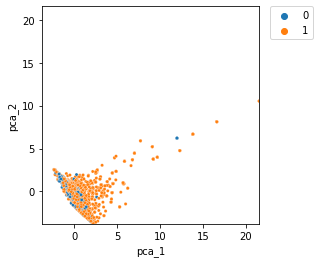

In [109]:
fig, ax = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df, ax=ax, s=10)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [110]:
X_tsne = TSNE(n_components=2).fit_transform(X_std)
# X_pca= pca.transform(X_std)
# print(relevant_data[output_column].to_numpy().reshape((relevant_data.shape[0])))
tsne_result_df = pd.DataFrame({
    'tsne_1': X_tsne[:,0],
    'tsne_2': X_tsne[:,1],
    'label': relevant_data[output_column].to_numpy().reshape((relevant_data.shape[0]))
})

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


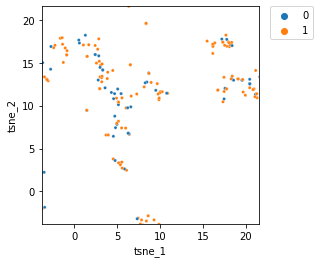

In [111]:
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=10)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

# Task 2

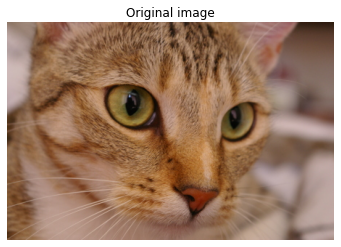

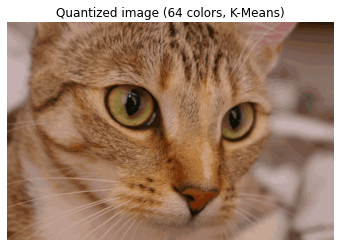

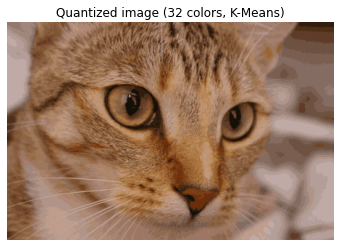

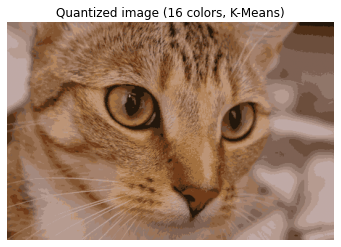

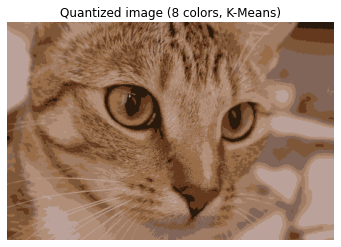

In [85]:
figure_idx = 1

def quantize_image(image, n_colors):

    # Convert to floats instead of the default 8 bits integer coding. Dividing by
    # 255 is important so that plt.imshow behaves works well on float data (need to
    # be in the range [0-1])
    chelsea = np.array(data.chelsea(), dtype=np.float64) / 255

    # Load Image and transform to a 2D numpy array.
    w, h, d = original_shape = tuple(chelsea.shape)
    assert d == 3
    image_array = np.reshape(chelsea, (w * h, d))

    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

    # Get labels for all points
    labels = kmeans.predict(image_array)
   
    def recreate_image(codebook, labels, w, h):
        """Recreate the (compressed) image from the code book & labels"""
        return codebook[labels].reshape(w, h, -1)
    
    global figure_idx
    plt.figure(figure_idx)
    figure_idx += 1
    plt.clf()
    plt.axis("off")
    plt.title(f"Quantized image ({n_colors} colors, K-Means)")
    plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))


n_colors = [64, 32, 16, 8]

# Load the kitty photo
chelsea = data.chelsea()
    
# Display all results, alongside original image
plt.figure(figure_idx)
figure_idx += 1
plt.clf()
plt.axis("off")
plt.title("Original image")
plt.imshow(chelsea)

for c in n_colors:
    quantize_image(chelsea, c)

# Task 3

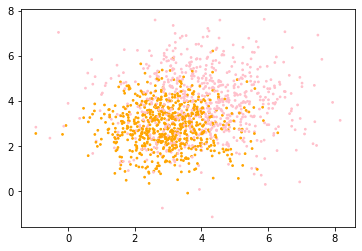

In [74]:
col = lambda labels: list(map(lambda x: 'orange' if x==0 else 'pink', labels))

num_points = 700

mean1 = (3, 3)
cov1 = [[1, 0], [0, 1]]
X1 = multivariate_normal(mean1, cov1, num_points)

mean2 = (4, 4)
cov2 = [[2, 0], [0, 2]]
X2 = multivariate_normal(mean2, cov2, num_points)

X = np.concatenate([X1, X2])
y = np.array([0] * num_points + [1] *  num_points) 
X, y = shuffle(X, y, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s = 3, c = col(y))


In [75]:
GMM = GaussianMixture(n_components=2, covariance_type='full')
GMM.fit(X)
print('means ')
print(GMM.means_)
print('covariances ')
print(GMM.covariances_)

means 
[[2.94009849 2.85911435]
 [4.2916058  4.17228977]]
covariances 
[[[ 1.06082824 -0.02776881]
  [-0.02776881  0.95710962]]

 [[ 1.68637917 -0.28869369]
  [-0.28869369  1.7018766 ]]]


means 
[[2.96608228 2.91535294]
 [4.19452597 4.03807919]]
covariances 
[1.03542013 1.83547619]


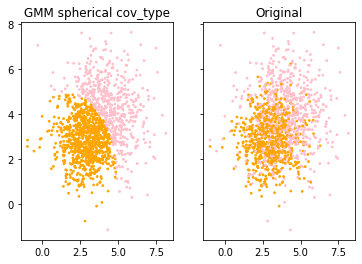

In [78]:
GMM = GaussianMixture(n_components=2, covariance_type='spherical')
GMM.fit(X)

print('means ')
print(GMM.means_)
print('covariances ')
print(GMM.covariances_)
labels = GMM.predict(X)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('GMM spherical cov_type')
ax1.scatter(X[:,0], X[:,1], c=col(labels), s=3)
ax2.set_title("Original")
ax2.scatter(X[:,0], X[:,1], c=col(y), s=3)

In [192]:


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
df = pd.read_csv('../Corona_NLP_train.csv')
df = df[:5000]
df_test = pd.read_csv('../Corona_NLP_test.csv')
df_test = df_test[:5000]
# df.head()
# print(df.shape)

In [193]:
# df.loc[:,'OriginalTweet'] = df.loc[:,'OriginalTweet'].map(lambda x: x.lower())



def preprocess_df(df):
    df['OriginalTweet'].replace(
        {r'[^a-zA-Z\ ]': r''},
        inplace = True,
        regex = True)

    stop_words = stopwords.words('english')

    def filter_stop_words(text_tokens):
        filtered_text = []
        for w in text_tokens:
            if w not in stop_words:
                filtered_text.append(w)
        return filtered_text
    #     print('text: ', text_tokens)
    #     print('filtered: ', filtered_text)

    df.loc[:,'OriginalTweetTokenized'] = df.loc[:,'OriginalTweet'].map(lambda x: filter_stop_words(word_tokenize(x)))
    df.loc[:,'Sentiment'] = df.loc[:,'Sentiment'].map(lambda x: x.replace('Extremely ', ''))
    # words = word_tokenize(text)
    df = df[['OriginalTweetTokenized', 'OriginalTweet', 'Sentiment']]

preprocess_df(df)
preprocess_df(df_test)

# df.head()
# print(df.shape)

Neutral:
Positive:
Negative:


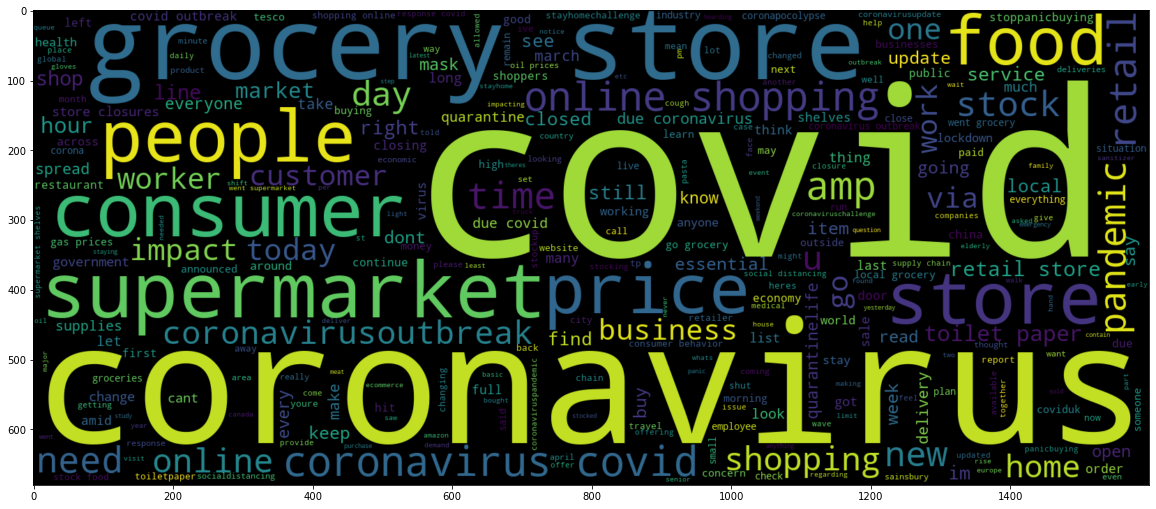

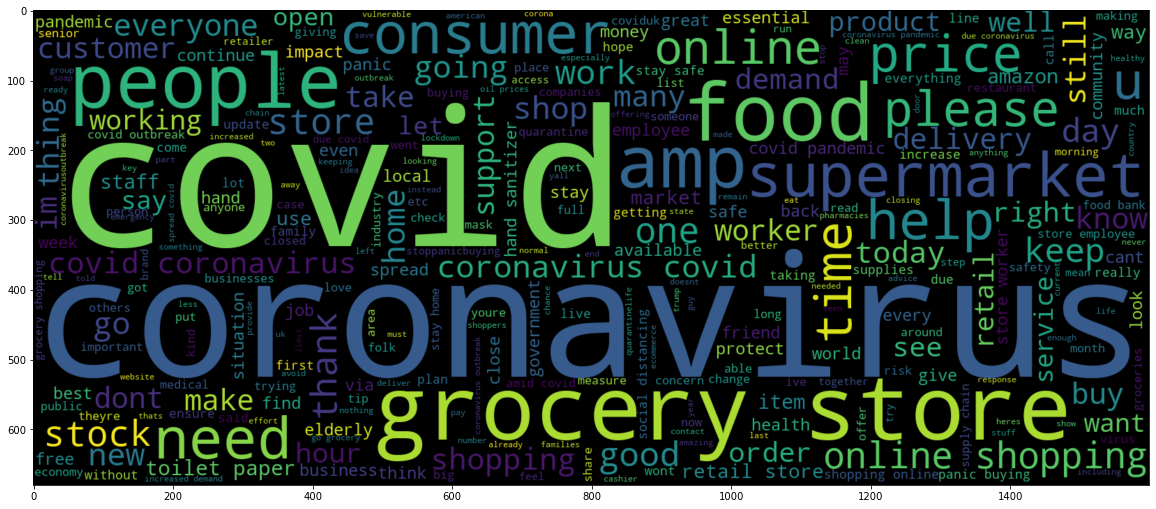

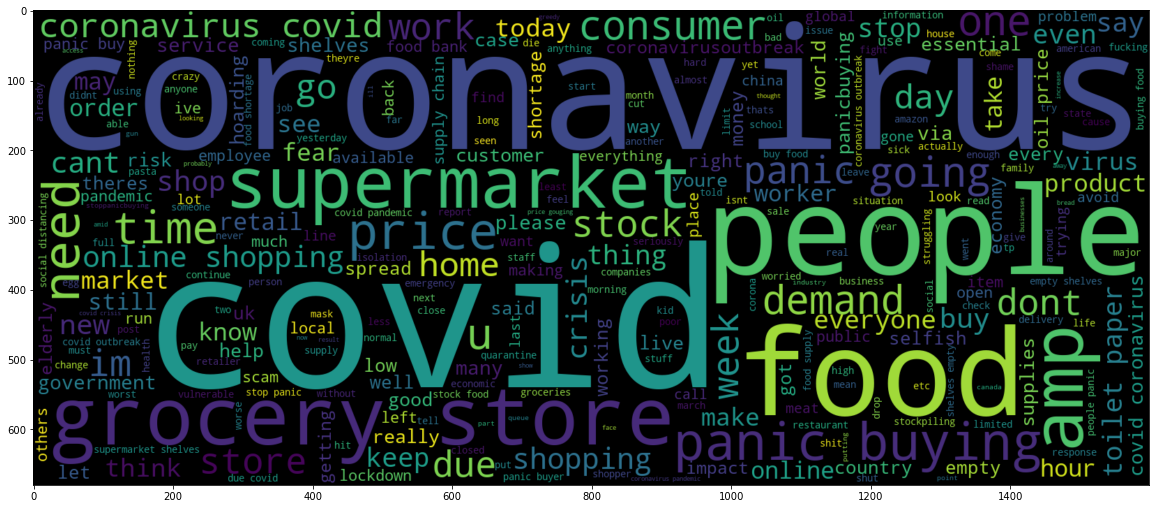

In [194]:
df['Sentiment'].value_counts()

def show_word_cloud(sentiment):
    whole_text_lower = ""
    for tokens in df[df['Sentiment']==sentiment].OriginalTweetTokenized:
        whole_text_lower += " ".join(tokens).lower() + " "
    # print(whole_text_lower)
    plt.figure(figsize = (20, 20)) 
    wordcould = WordCloud(min_font_size = 3, max_words = 300, width = 1600, height = 680).generate(whole_text_lower)
    print(sentiment + ':')
    plt.imshow(wordcould, interpolation = 'bilinear')
    plt.grid(False)
    
for sentiment in df['Sentiment'].unique():
    show_word_cloud(sentiment)

In [196]:
tfidf_vectorizer = TfidfVectorizer(max_df=500, min_df=10)

tfidf_train = tfidf_vectorizer.fit_transform(df['OriginalTweet'])
tfidf_test =  tfidf_vectorizer.transform(df_test['OriginalTweet'])

clf = LogisticRegression().fit(tfidf_train, df['Sentiment'])

predicted = clf.predict(tfidf_test)
print(classification_report(df_test['Sentiment'], predicted))

              precision    recall  f1-score   support

    Negative       0.67      0.72      0.69      1633
     Neutral       0.58      0.31      0.41       619
    Positive       0.68      0.75      0.71      1546

    accuracy                           0.67      3798
   macro avg       0.64      0.59      0.60      3798
weighted avg       0.66      0.67      0.65      3798



/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


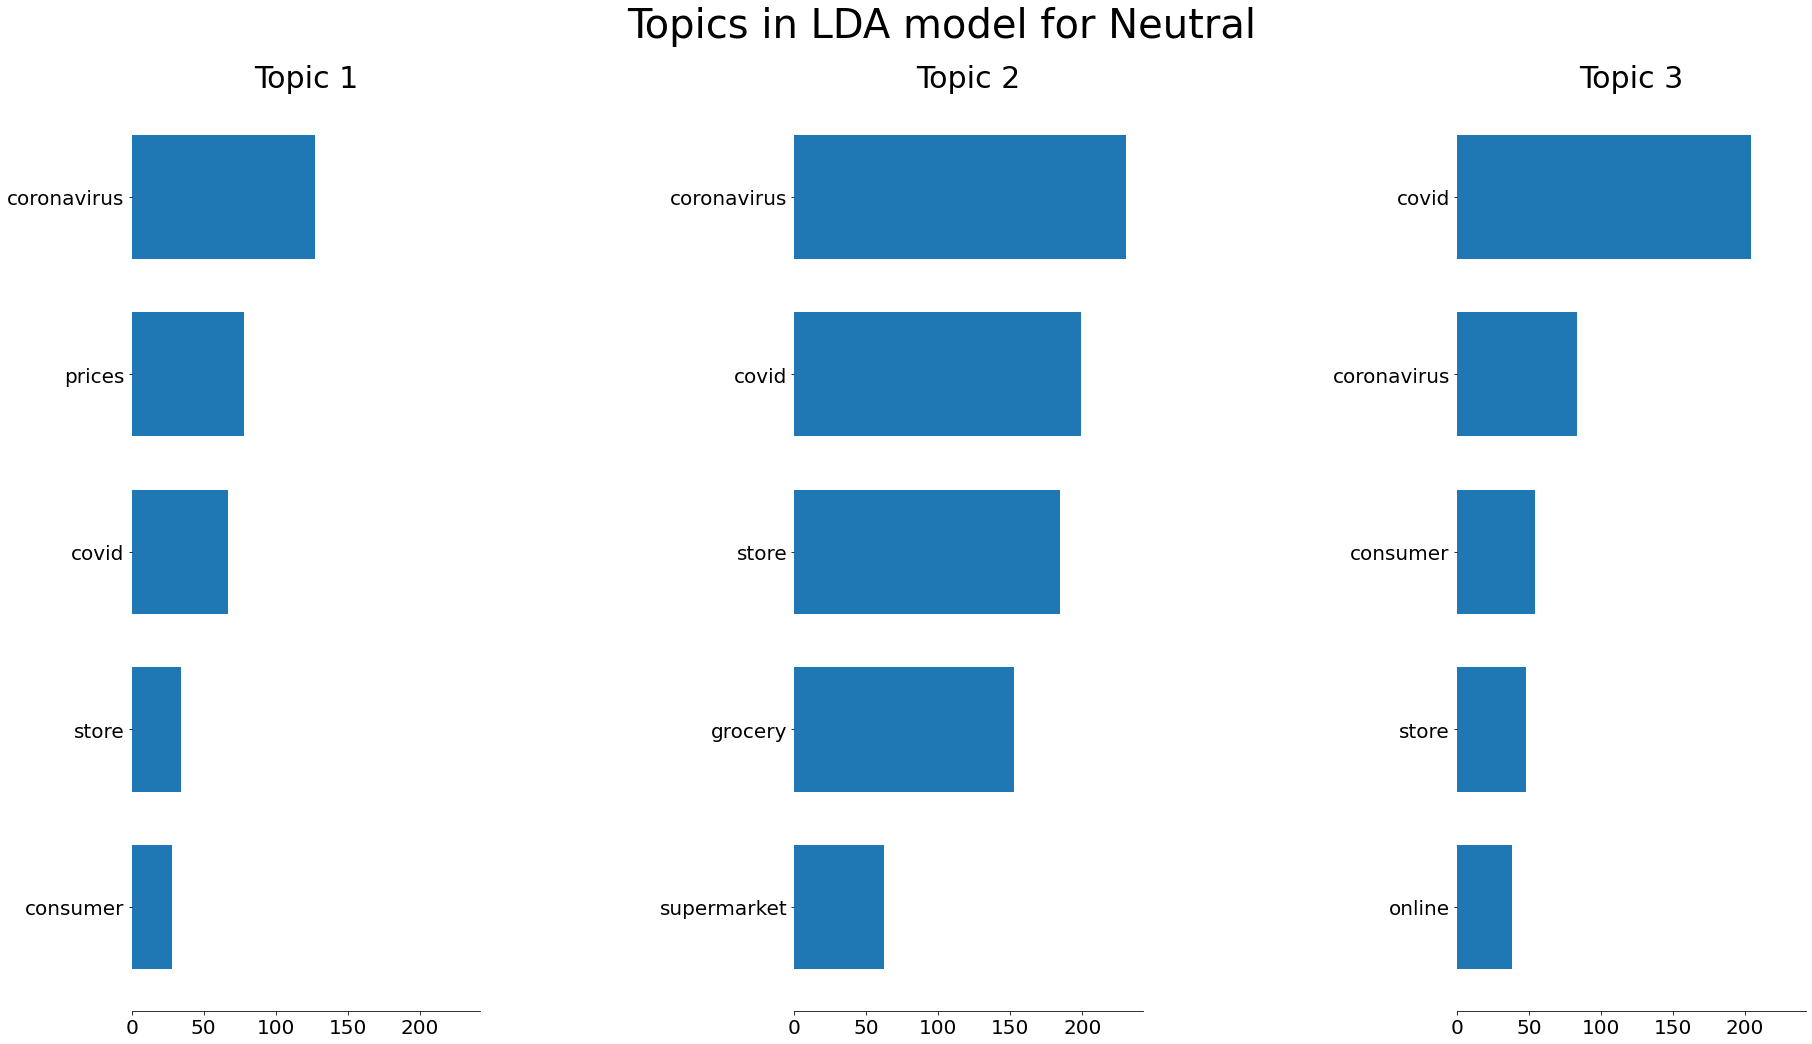

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


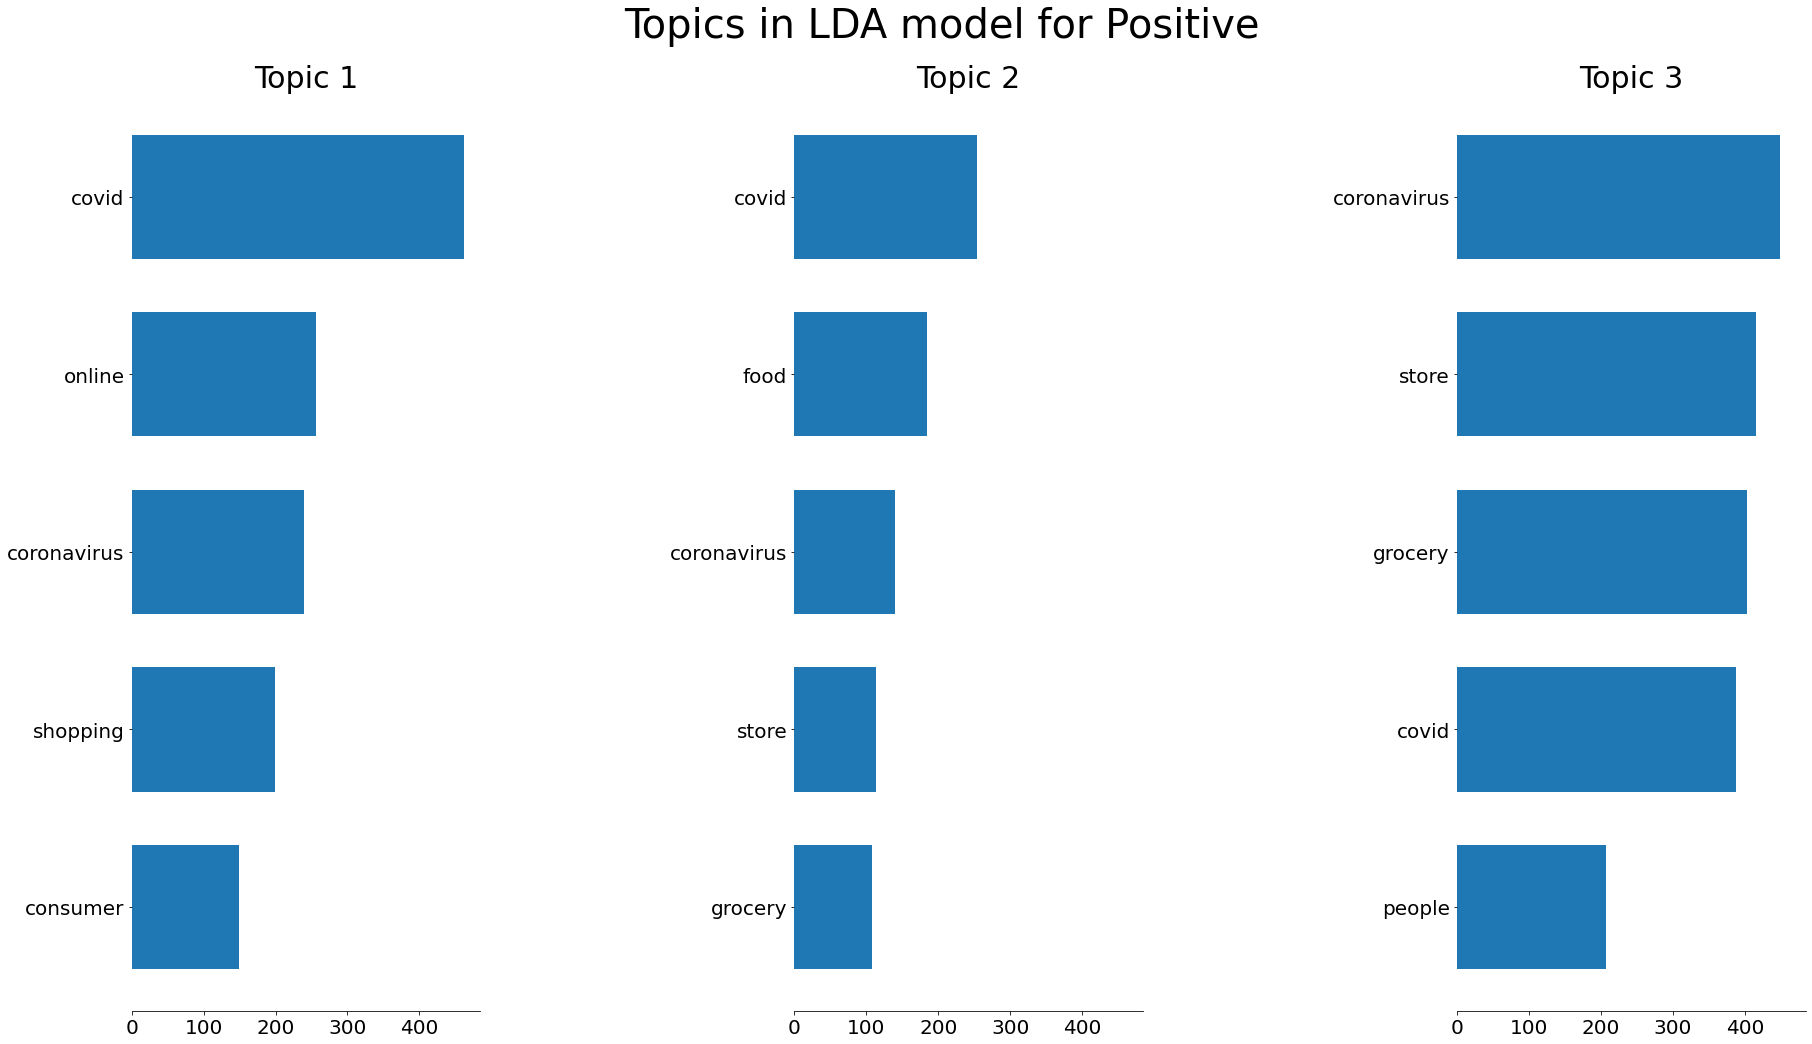

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


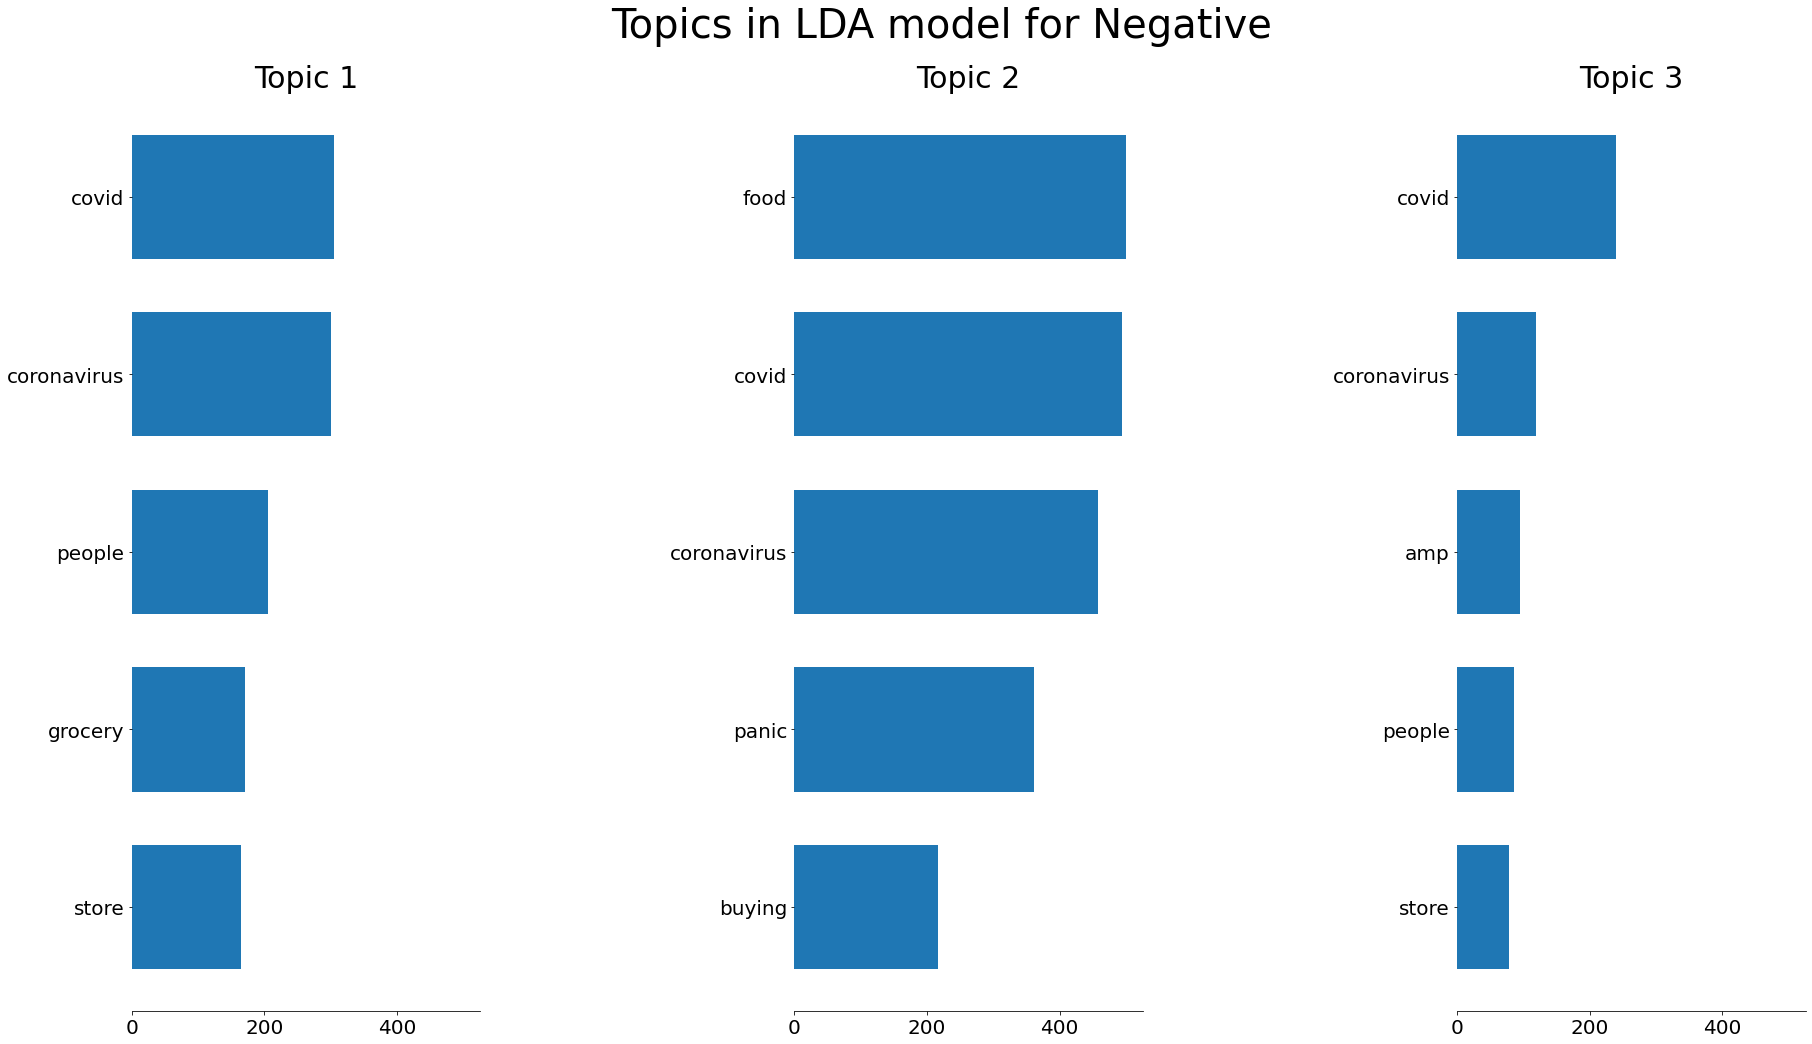

In [205]:
n_components = 3
n_top_words = 5

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, n_components, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

def lda_per_class(sentiment):
    vectorizer = CountVectorizer(stop_words='english')

    data_vectorized = vectorizer.fit_transform(df[df['Sentiment']==sentiment].OriginalTweet)

    lda = LatentDirichletAllocation(n_components=n_components, random_state=0)

    lda.fit(data_vectorized)

    feature_names = vectorizer.get_feature_names()

    plot_top_words(lda, feature_names, n_top_words, f'Topics in LDA model for {sentiment}')
    
for sentiment in df['Sentiment'].unique():
    lda_per_class(sentiment)